# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Image
import datetime
from scipy import stats as ss
from boruta import BorutaPy
import random
import pickle
import requests
import xgboost as xgb
from sklearn import metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

In [2]:
print(np.__version__)

1.23.1


## Helper Functions

In [3]:
def cross_validation(model_name, model,x_training, kfold):
    mae_list = []
    mape_list = []
    rmse_list = []
        
    for k in reversed(range(1, kfold + 1)): 
        # print('Kfold: {}'.format(k))
        #stard and end date for validaion
        valid_start_date = x_trainning['date'].max() - datetime.timedelta(days=k*6*7)
        valid_end_date = x_trainning['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        #filter
        
        training = x_trainning.loc[x_trainning['date'] < valid_start_date,: ]
        validation = x_trainning.loc[(x_trainning['date'] >= valid_start_date) & (x_trainning['date'] <= valid_end_date),: ]
        
        #training e validation dataset
        
        #training
        xtraining = training.drop(['date', 'sales'],axis=1)
        ytraining = training['sales']
        
        #validation
        xvalidation = validation.drop(['date', 'sales' ],axis=1)
        yvalidation = validation['sales']
        
        #model defitinion
        
        m = model.fit(xtraining, ytraining)
        
        #prediction
        yhat = m.predict(xvalidation)
        #performance
        
        m_result = ml_result(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        metric = pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + '+/-' + np.round(np.std(mae_list),2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str) }, index = [0])
    return metric 

def ml_result(model_name, y, yhat):
    name = model_name
    mae = mt.mean_absolute_error(y,yhat)
    mape = mt.mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mt.mean_squared_error(y,yhat))



    return pd.DataFrame({'Model Name': name , 'MAE': mae, 'MAPE': mape, "RMSE": rmse  }, index=[0])

## Load Data

In [4]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory=False)

#unindo as duas tabelas através de um left join utilizando a chave estrangeira Store

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


low_memory = False -> Os dados são carregados de uma vez só, caso seja False, os dados são carregados em partes.

In [5]:

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
238102,945,2,2014-12-30,5707,664,1,0,0,1,a,c,12480.0,3.0,2011.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

## 1.1 Rename Columns

In [6]:
df1 = df_raw.copy()

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [8]:
#trocando as colunas para snake_case
snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

# rename columns

df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Existem três maneira de se tratara um NA 
1. Excluir os NA's: Vantagem é uma forma rápida, desvantagem é que estamos jogando os dados fora. Principalmente se o resto das colunas tem um valor importante para o negócio
2. Utilizando algoritímos de ML: substituindo as colunas pelo comportamento da coluna, ou seja, calculo da mediana, média, algoritímo para prever qual o valor que estaria no local.
3. Através do entedimento do negócio: Será que é uma regra ou lógica de negócio definido pelo time de negócios?

## 1.5 Fillout NA

#### 1.5.1 competition_distance: distance in meters to the nearest competitor store

- A partir do entendimento do negócio, assumimos que os valores faltantes nesta coluna são consequências de não haver lojas que realizam competição em distâncias curtas, ou a distância é muito grande que nem é computada no dataset. Por isso, a opção por substituir os NA's desta coluna por uma distância muito maior que a distância máxima do meu dataset parece razoável.

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.00 if math.isnan(x) else x)

#### 1.5.2 competition_open_since_month: gives the approximate year and month of the time the nearest competitor was opened
- competition_open_since_year

- Aqui o valor pode estar nulo pela loja concorrente ter aberto antes da minha loja e eu não ter essa data, ou abriu depois e esquecemos de anotar. Para preencher esse NA levamos em conta etapas do feature engineering em que o tempo é muito importante. A solução é pegar a data da última venda.

In [16]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [17]:
                       
# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
             
          

#### 1.5.3 Promo_interval
- A coluna indica uma promoção continua nas lojas, se o valor é nulo quer dizer que a loja não esta realizando promoção

    

In [18]:
month_map = {1 : 'Jan', 
 2 : 'Feb', 
 3 : 'Mar',
 4 : 'Apr',
 5 : 'May',
 6 : 'Jun',
 7 : 'Jul',
 8 : 'Aug',
 9 : 'Sept',
 10 : 'Oct',
 11 : 'Nov',
 12 : 'Dec'}

In [19]:
df1['promo_interval'].fillna(0, inplace=True)    

In [20]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)

In [21]:
df1.sample(5).T

,430848,336470,320168,953470,36433
store,129,55,689,931,754
day_of_week,2,1,5,3,1
date,2014-06-10 00:00:00,2014-09-15 00:00:00,2014-10-03 00:00:00,2013-02-27 00:00:00,2015-06-29 00:00:00
sales,9184,6429,0,2815,10009
customers,1267,724,0,352,1011
open,1,1,0,1,1
promo,0,1,1,0,1
state_holiday,0,0,a,0,0
school_holiday,1,0,0,0,0
store_type,a,a,d,a,c


In [22]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [24]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statiscal

Antes de calcular a estatística descritiva devo separar meus dados em numéricos e categóricos

### 1.7.1 Numerical Attributes

In [26]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [27]:
#Central tendence - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1, ct2, d1,d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']



In [28]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_9008/710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

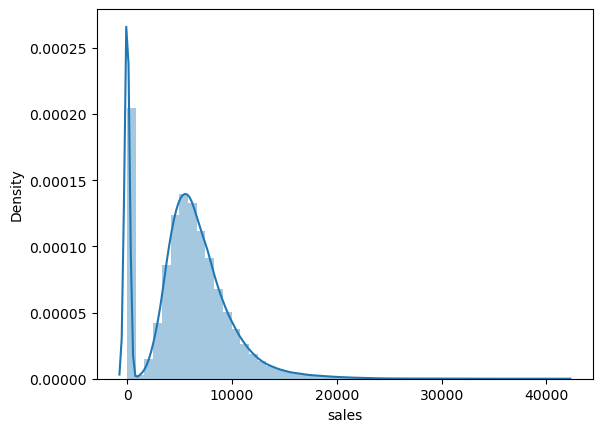

In [29]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [30]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [31]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

<Axes: xlabel='assortment', ylabel='sales'>

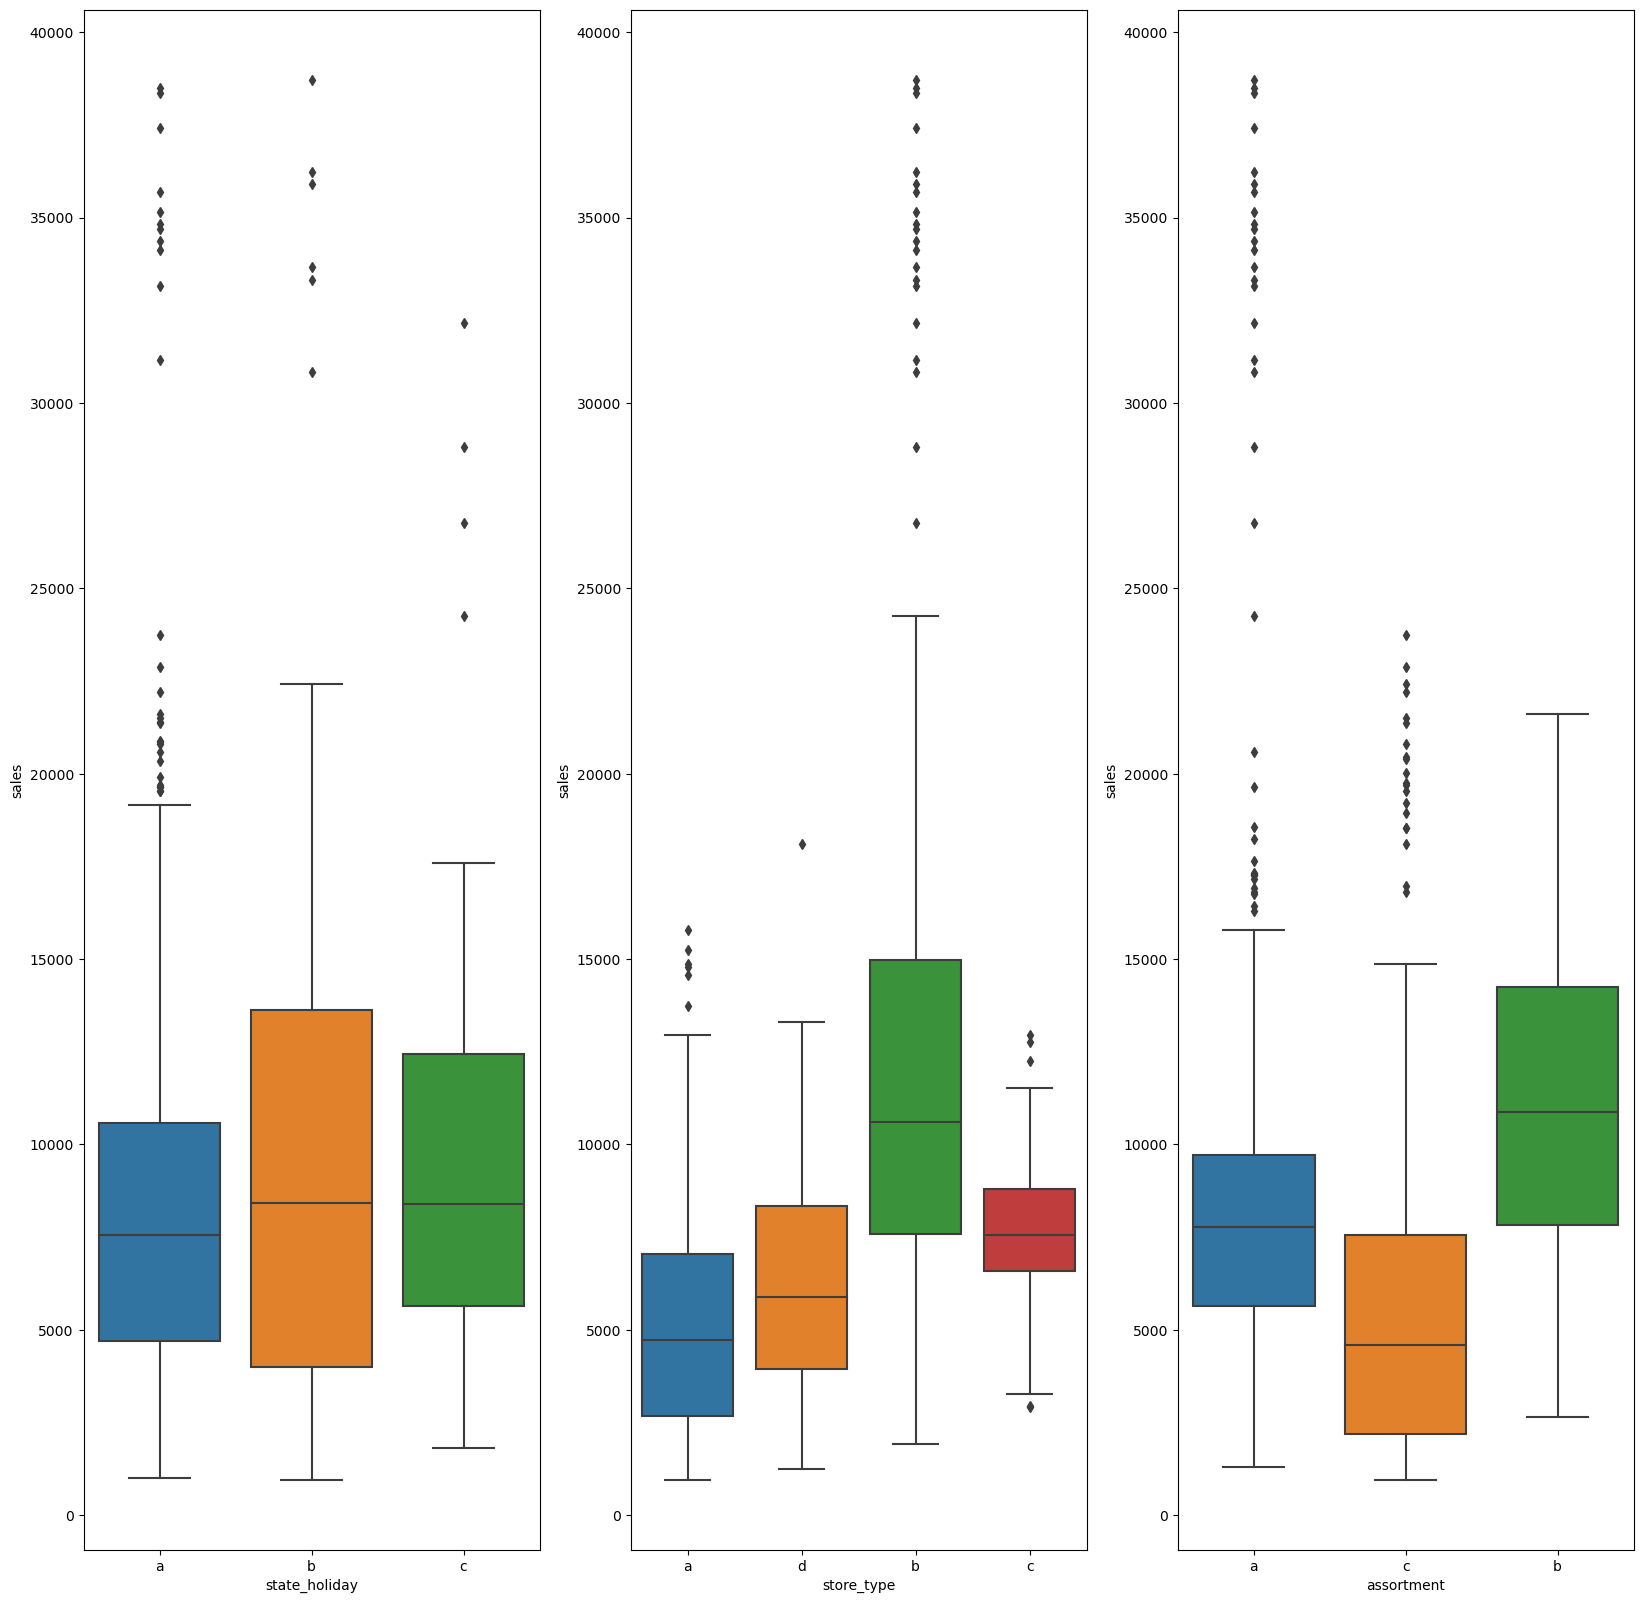

In [32]:
aux = df1[(df1['sales'] > 0 ) & (df1['state_holiday'] != '0')]

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)



# 2.0 FEATURE ENGINEERING

In [33]:
df2 = df1.copy()

In [34]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
251002,722,2,2014-12-16,15871,2206,1,1,0,0,a,a,50.0,12,2014,0,51,2014,0,Dec,0
152561,922,2,2015-03-17,6860,700,1,1,0,0,d,a,2110.0,3,2006,0,12,2015,0,Mar,0
440456,817,1,2014-06-02,31185,3858,1,1,0,0,a,a,140.0,3,2006,0,23,2014,0,Jun,0
77259,325,6,2015-05-23,3909,432,1,0,0,0,a,c,350.0,3,2011,1,22,2011,"Feb,May,Aug,Nov",May,1
454693,559,2,2014-05-20,7049,886,1,1,0,0,d,a,3910.0,11,2006,1,5,2013,"Feb,May,Aug,Nov",May,1


## 2.1 Mapa mental de hipóteses

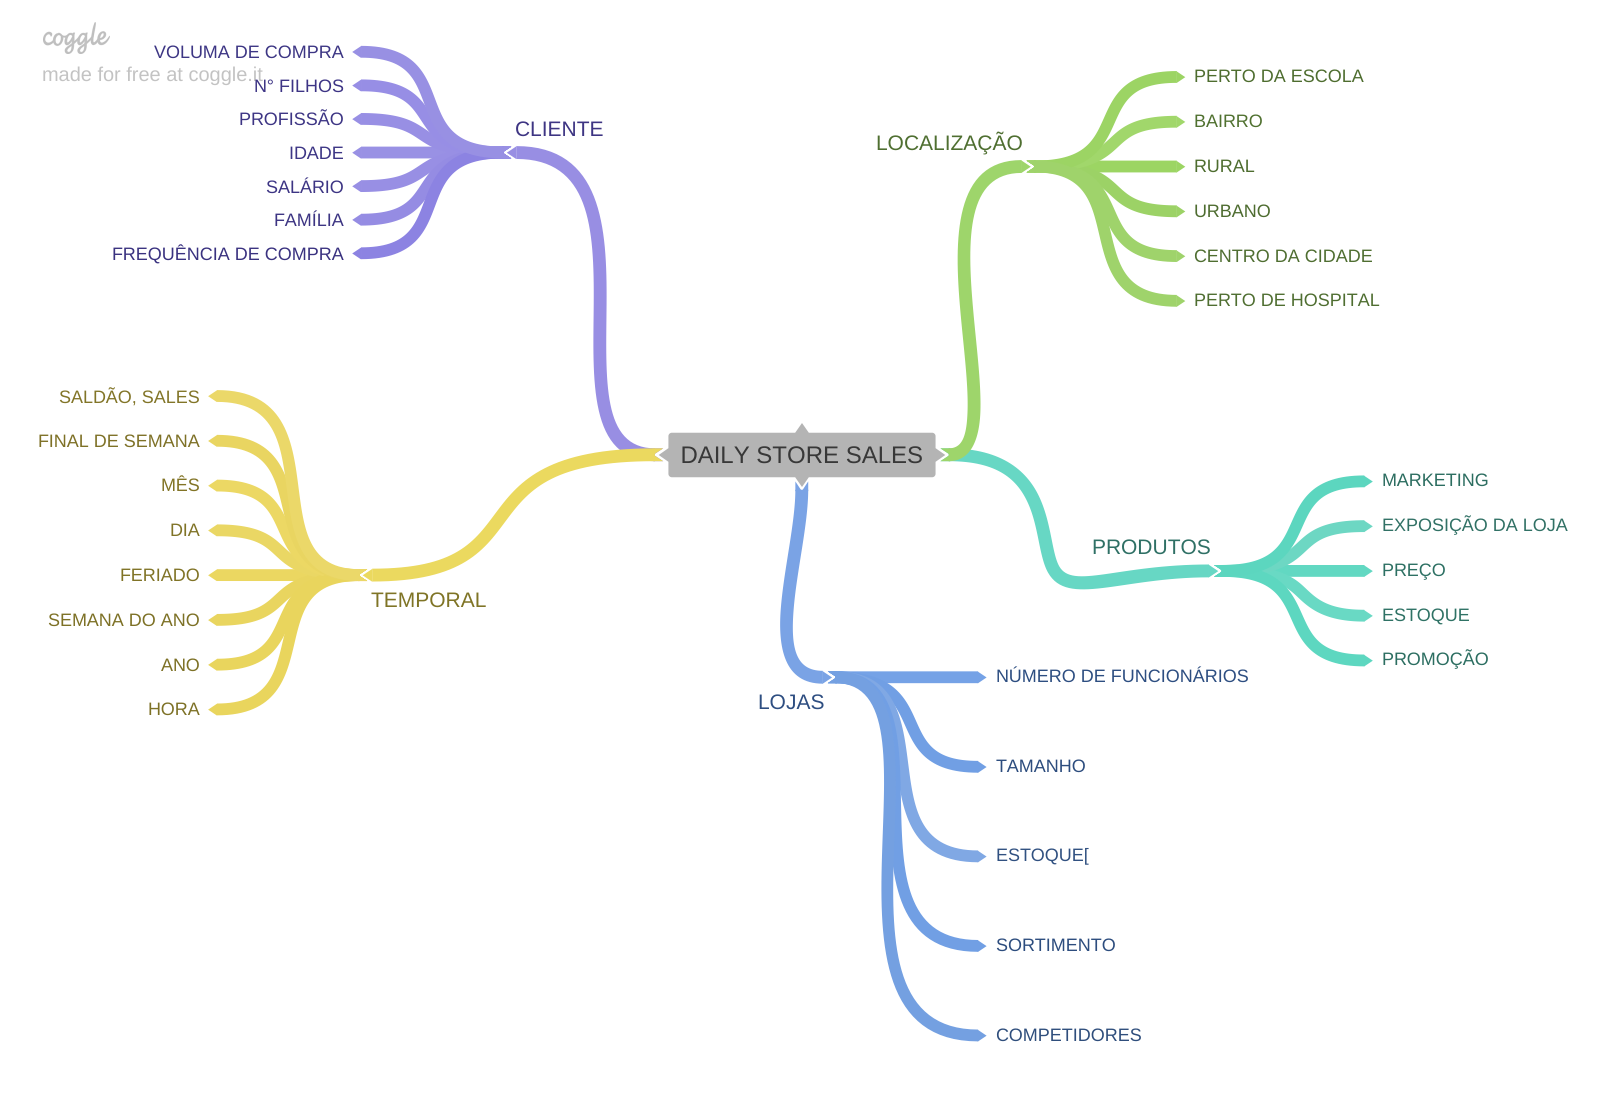

In [35]:
Image('img/mindmap.png')

## 2.2 Criação das HIpóteses

### 2.2.1 Hipóteses Lojas

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Temporal

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.


### 2.2.4 Lista final de HIpóteses

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [36]:
df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
619510,356,1,2013-12-23,12671,915,1,0,0,1,d,c,8970.0,12,2007,1,22,2012,"Feb,May,Aug,Nov",Dec,0


In [37]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year-week
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")
#competition since

df2['competition_since'] = df2.apply(lambda x : datetime.datetime(year = x['competition_open_since_year'], month=  x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

#promo_since
df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w") - datetime.timedelta(days=7))
df2['promo_time_week']=((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment

df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else  'extra' if x == 'b' else 'extended')

#state_holiday

df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public holiday' if x =='a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day') 


/tmp/ipykernel_9008/304016164.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [38]:
display(df2.head().T)
display(df2.dtypes)

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 Filtragem de Variáveis

In [39]:
df3 = df2.copy()

In [40]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Fitragem de Variáveis

In [41]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

## 3.2 Selecionando Variáveis

In [42]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados.

In [43]:
df4= df3.copy()

## 4.1 Análise Univariada

Na analise univariada procuramos analisar somente uma variável através de análises estatísticas de tendência central e dispersão

### 4.1.1 Response Variable

/tmp/ipykernel_9008/816018401.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales']);


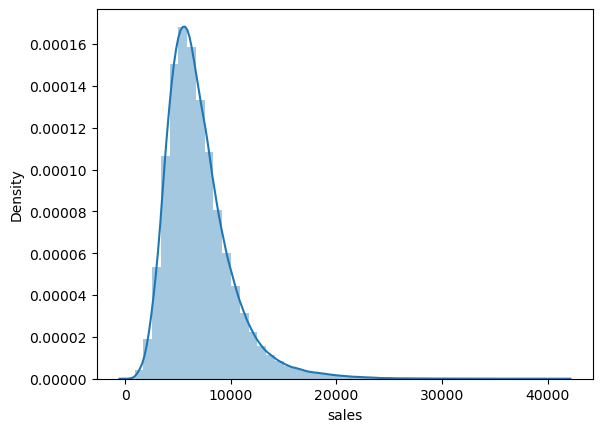

In [44]:
sns.distplot(df4['sales']);

Quanto mais normal for a variável responsta, melhor a performance do algoritimo.

### 4.1.2 Numerical variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

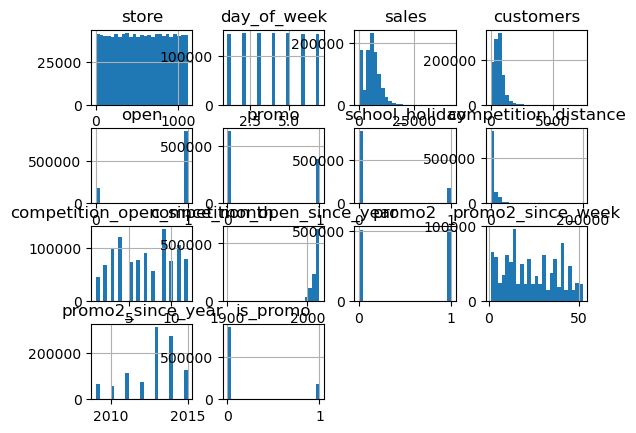

In [45]:

num_attributes.hist(bins=25)

### 4.1.3 Categorical Variable

In [46]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public holiday
129424    Easter holiday
241126         Christmas
Name: state_holiday, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

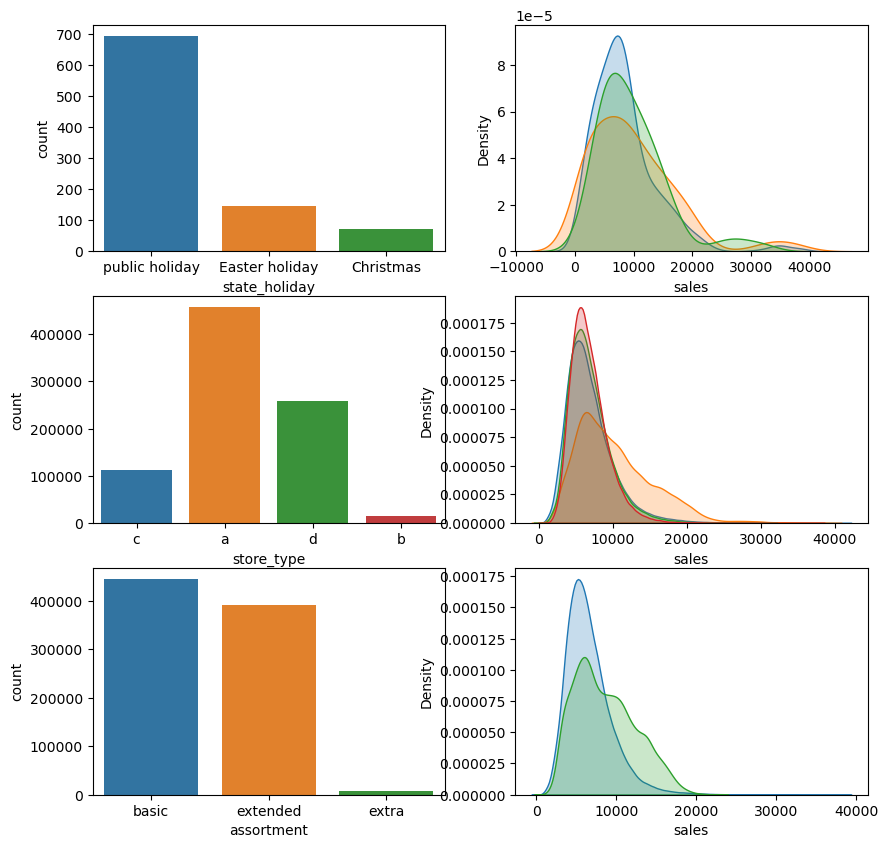

In [47]:
# state_holiday
#subplot(linhas,colunas,localização na matriz)
plt.figure(figsize=(10,10))
a = df4.loc[df4['state_holiday'] != 'regular_day', :]
plt.subplot(3,2,1)
sns.countplot(a, x='state_holiday')
plt.subplot(3,2,2)

sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday',fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label='Easter holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', fill=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4, x='store_type')
plt.subplot(3,2,4)

sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4, x='assortment')
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)




## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**Falsa** -> lojas com maior sortimento vendem menos


<Axes: xlabel='year_week'>

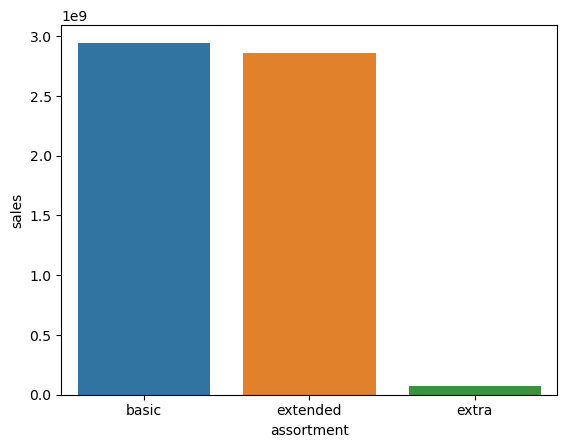

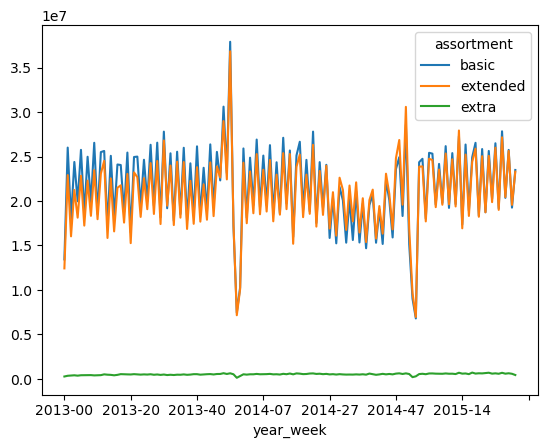

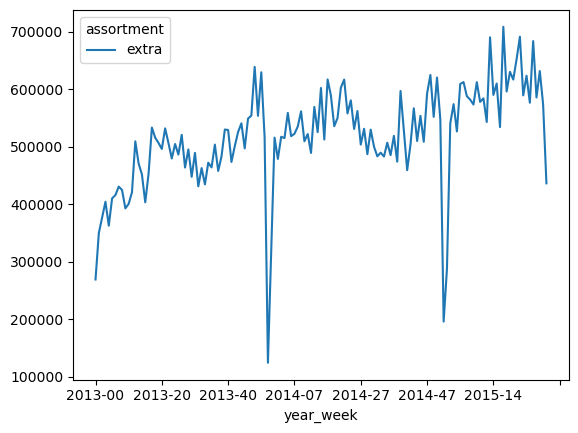

In [48]:
aux1 = df4.loc[:, ['sales', 'assortment']].groupby(['assortment']).sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales')

aux2 = df4.loc[:, ['sales', 'assortment', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns='assortment', values= 'sales').plot()

aux4 = aux2.loc[aux2['assortment'] == 'extra', :]
aux4.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.


/tmp/ipykernel_9008/3947932490.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True)


<Axes: >

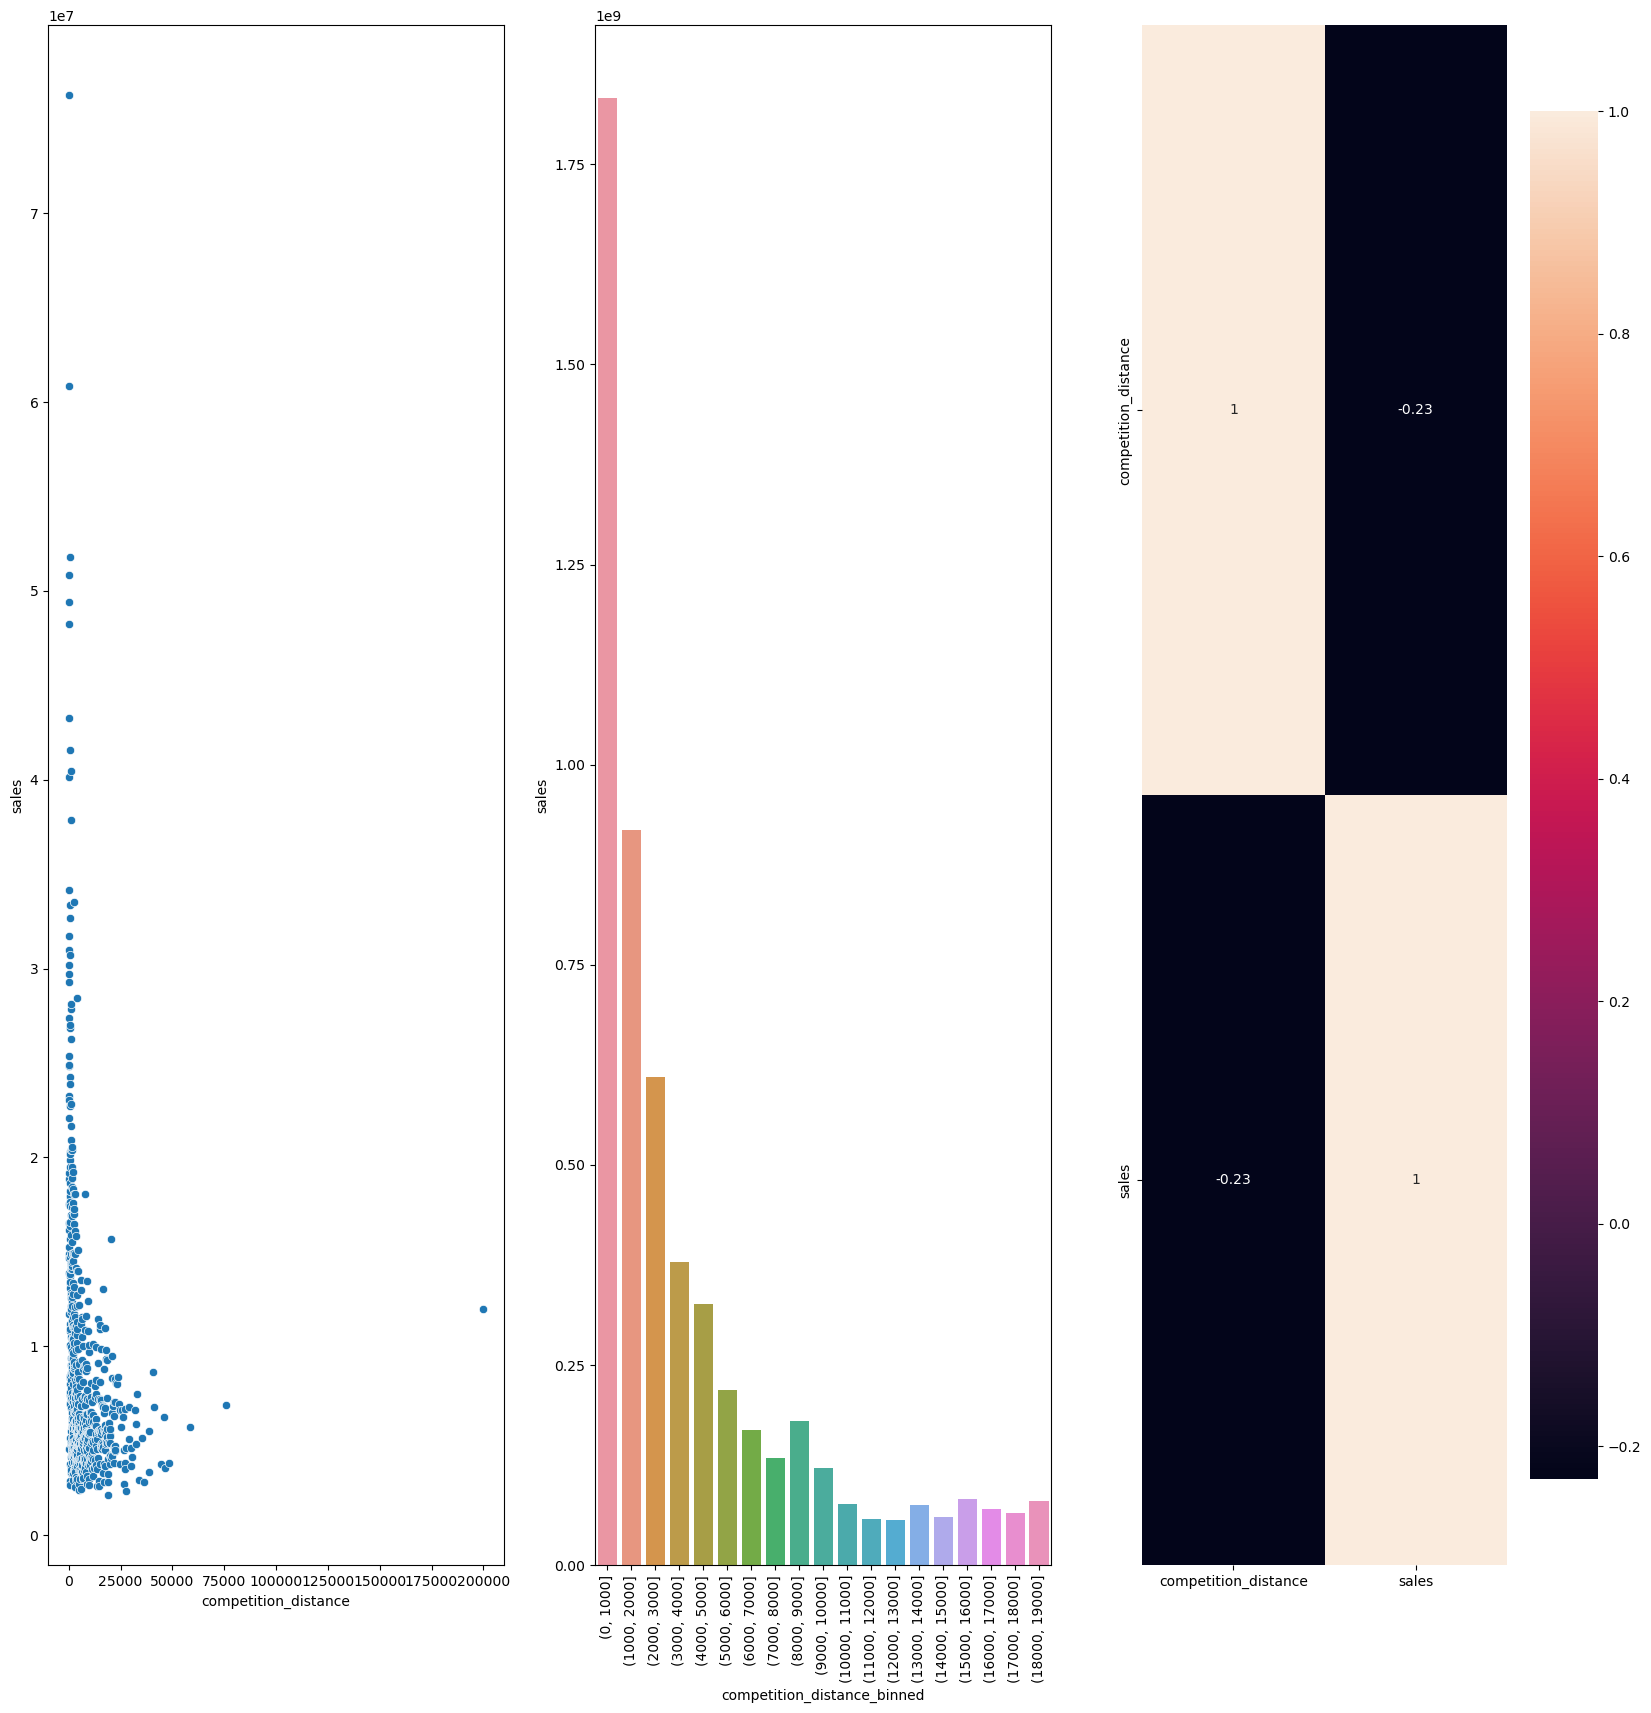

In [49]:
aux1 = df4.loc[:, ['sales', 'competition_distance']].groupby(['competition_distance']).sum().reset_index()

bins = np.arange(0, 20000, 1000)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 )
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1.loc[:, ['sales', 'competition_distance_binned']].groupby(['competition_distance_binned']).sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### H3. Lojas com competidores à mais tempo deveriam vendem mais.

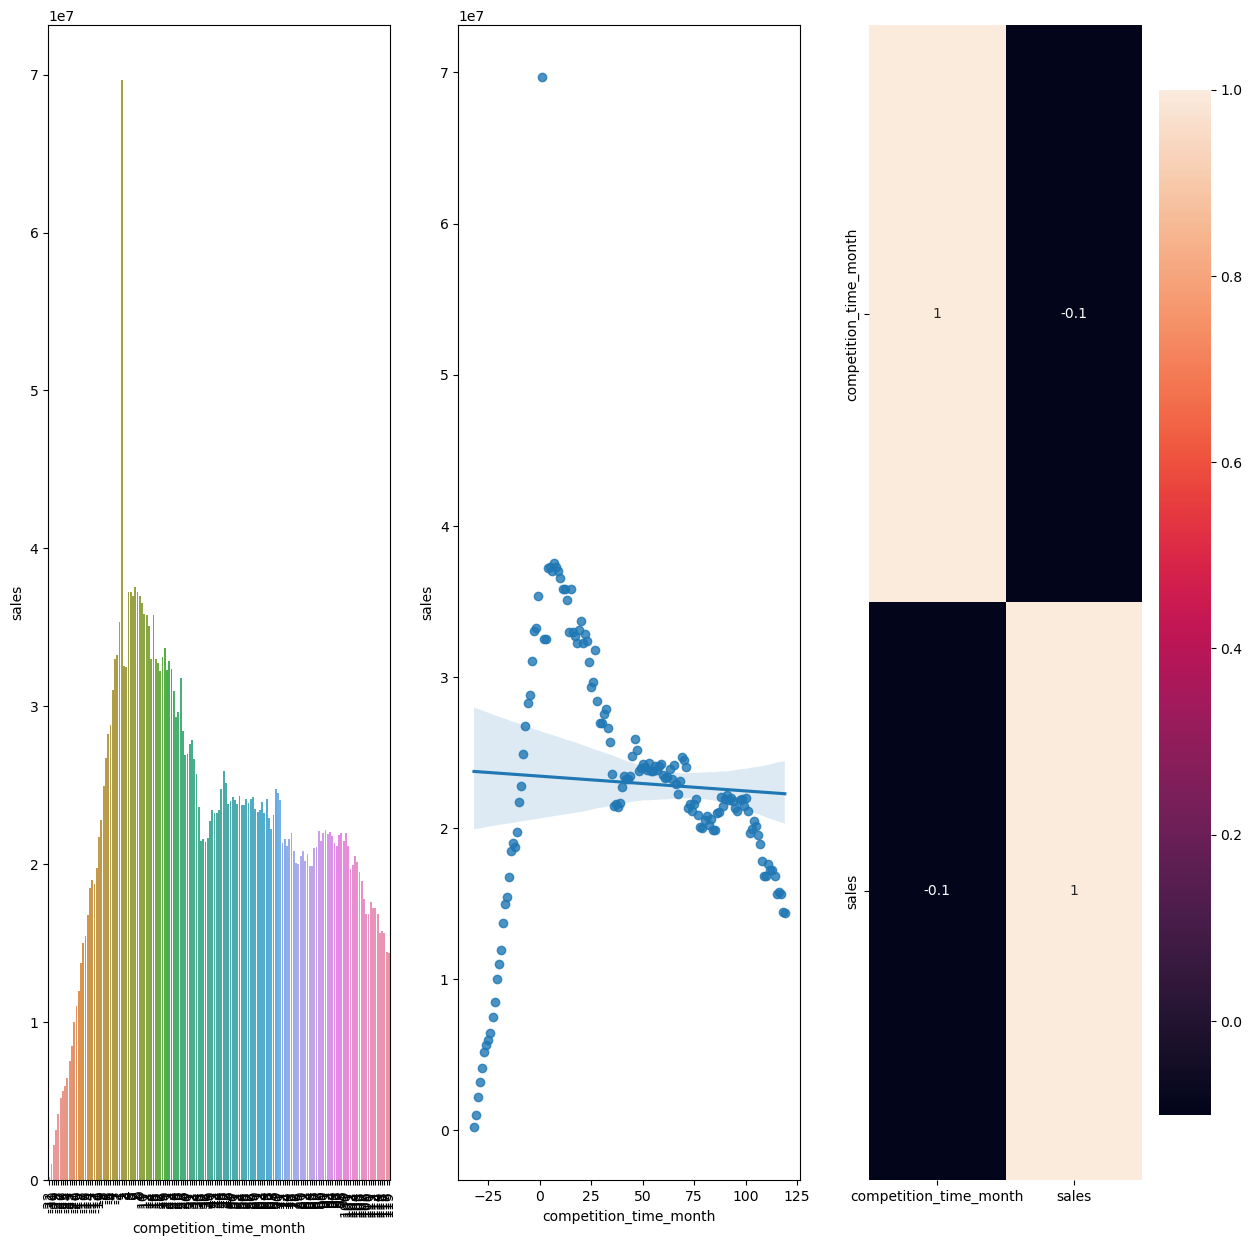

In [50]:
aux1 = df4.loc[:, ['sales','competition_time_month']].groupby(['competition_time_month']).sum().reset_index()
plt.figure(figsize=(15,15))
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
plt.subplot( 1, 3, 1 )
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation=90 )
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 )
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True )

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falsa** -> Lojas com promoção ativa por mais tempo vendem menos depois de um certo período de promoção

<Axes: >

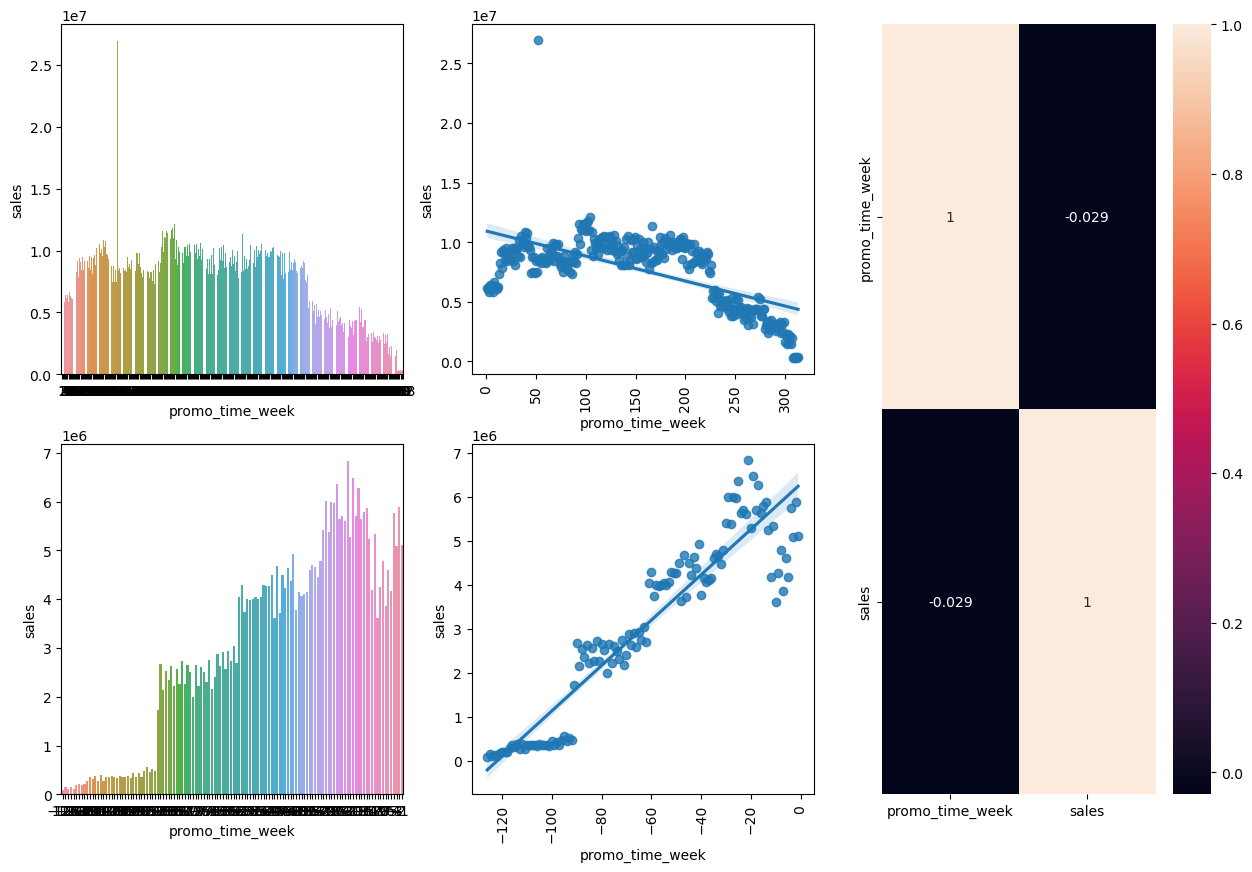

In [51]:
aux1 = df4.loc[:, ['sales', 'promo_time_week']].groupby(['promo_time_week']).sum().reset_index()

grid = plt.GridSpec(2,3)

#vendas no período da promoção extendida
aux2 = aux1.loc[aux1['promo_time_week'] > 0, :]
plt.figure(figsize=(15,10))
plt.subplot(grid[0,0])
sns.barplot(aux2,x='promo_time_week', y='sales')
plt.subplot(grid[0,1])
sns.regplot(aux2,x='promo_time_week', y='sales')

plt.xticks(rotation = 90)
#vendas no período regular da promoção
aux3 = aux1.loc[aux1['promo_time_week'] < 0 , :]
plt.subplot(grid[1,0])
sns.barplot(data=aux3, x='promo_time_week', y='sales')
plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales')

plt.xticks(rotation=90)
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr('pearson'), annot=True)

### H5. Lojas com mais dias de promoção deveriam vender mais.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

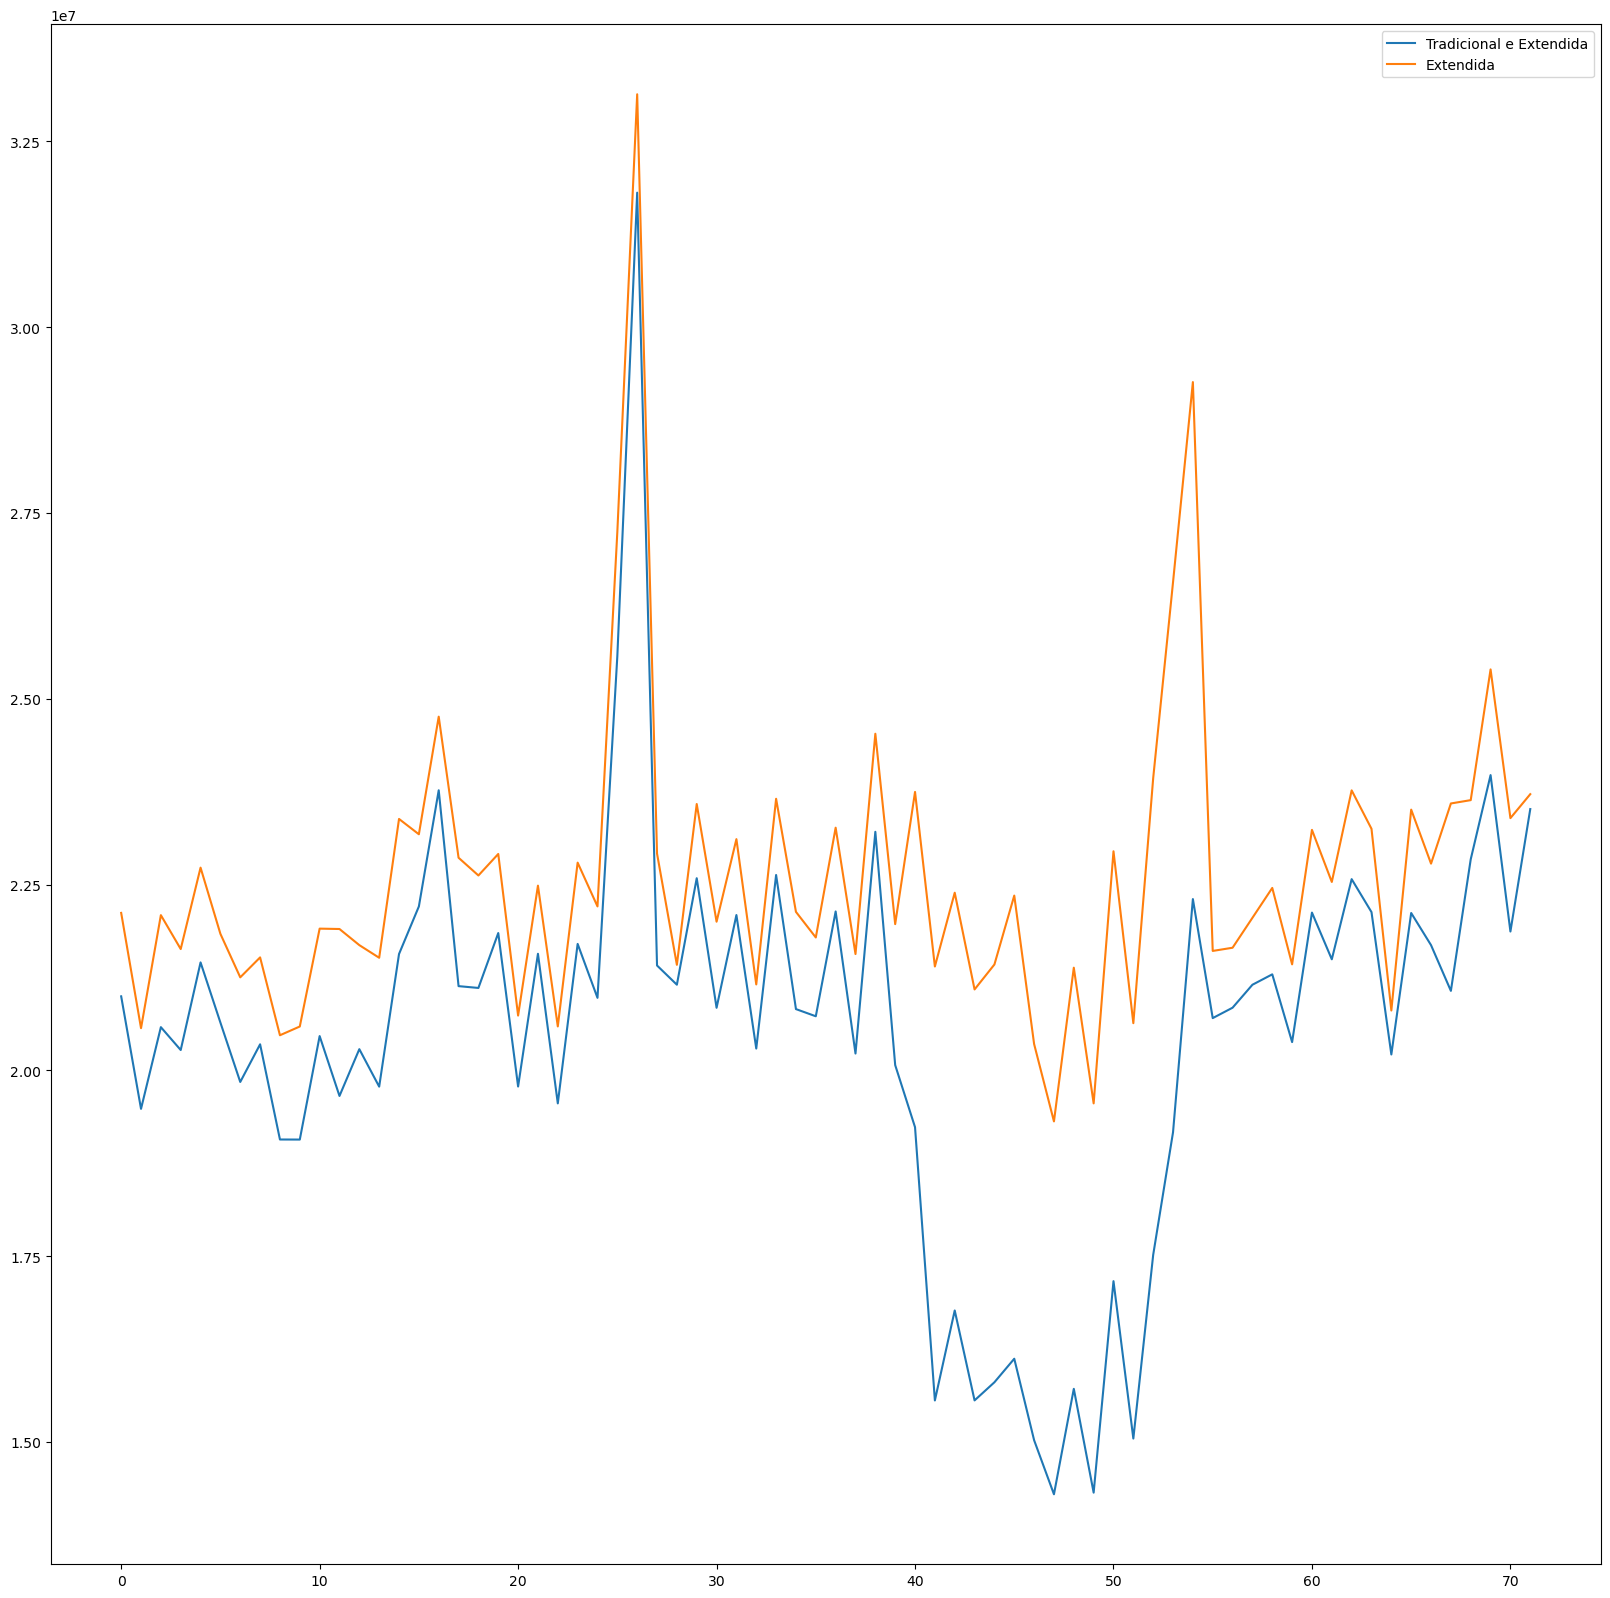

In [52]:
aux1 = df4.loc[(df4['promo'] == 1) &  (df4['promo2'] == 1), ['sales', 'year_week']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4.loc[(df4['promo'] == 1) &  (df4['promo2'] == 0), ['sales', 'year_week']].groupby(['year_week']).sum().reset_index()
aux2.plot(ax=ax,figsize=(20,20))

plt.legend(labels = ['Tradicional e Extendida', 'Extendida'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** -> Lojas abertas durante o feriado de natal vendem menos

<Axes: xlabel='year', ylabel='sales'>

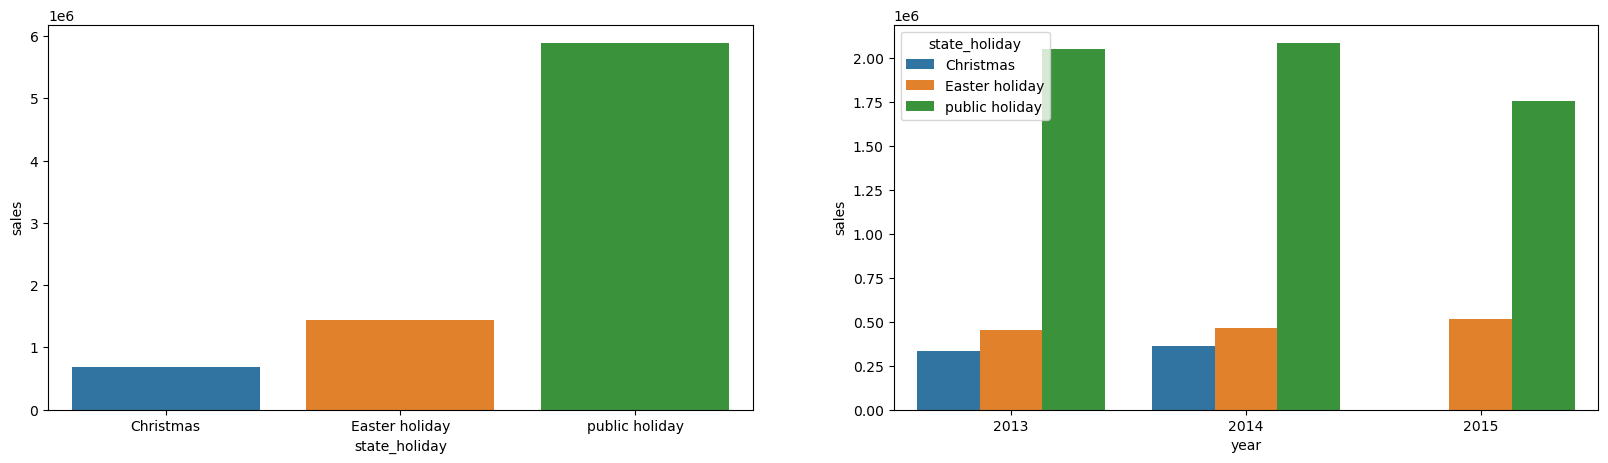

In [53]:
aux1 = df4.loc[df4['state_holiday'] != 'regular_day', ['sales', 'state_holiday']].groupby(['state_holiday']).sum().reset_index()
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(data=aux1, x='state_holiday', y='sales')
plt.subplot(1,2,2)
aux2 = df4.loc[df4['state_holiday'] != 'regular_day', ['sales','year', 'state_holiday']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday')

### H8. Lojas deveriam vender mais ao longo dos anos.

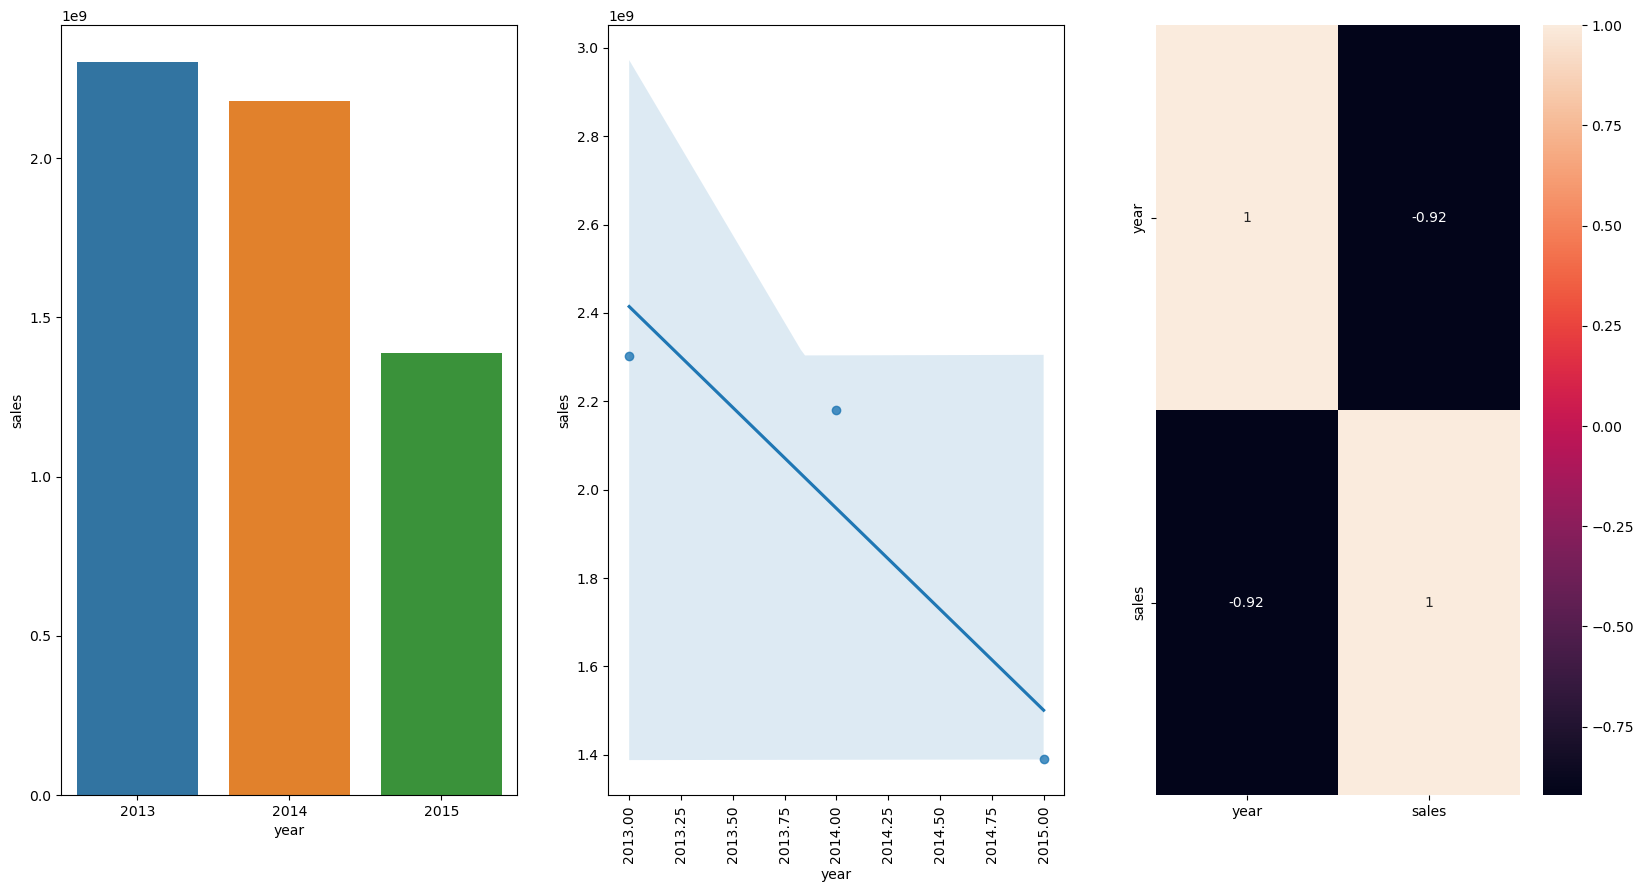

In [54]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.xticks(rotation=90)
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano.

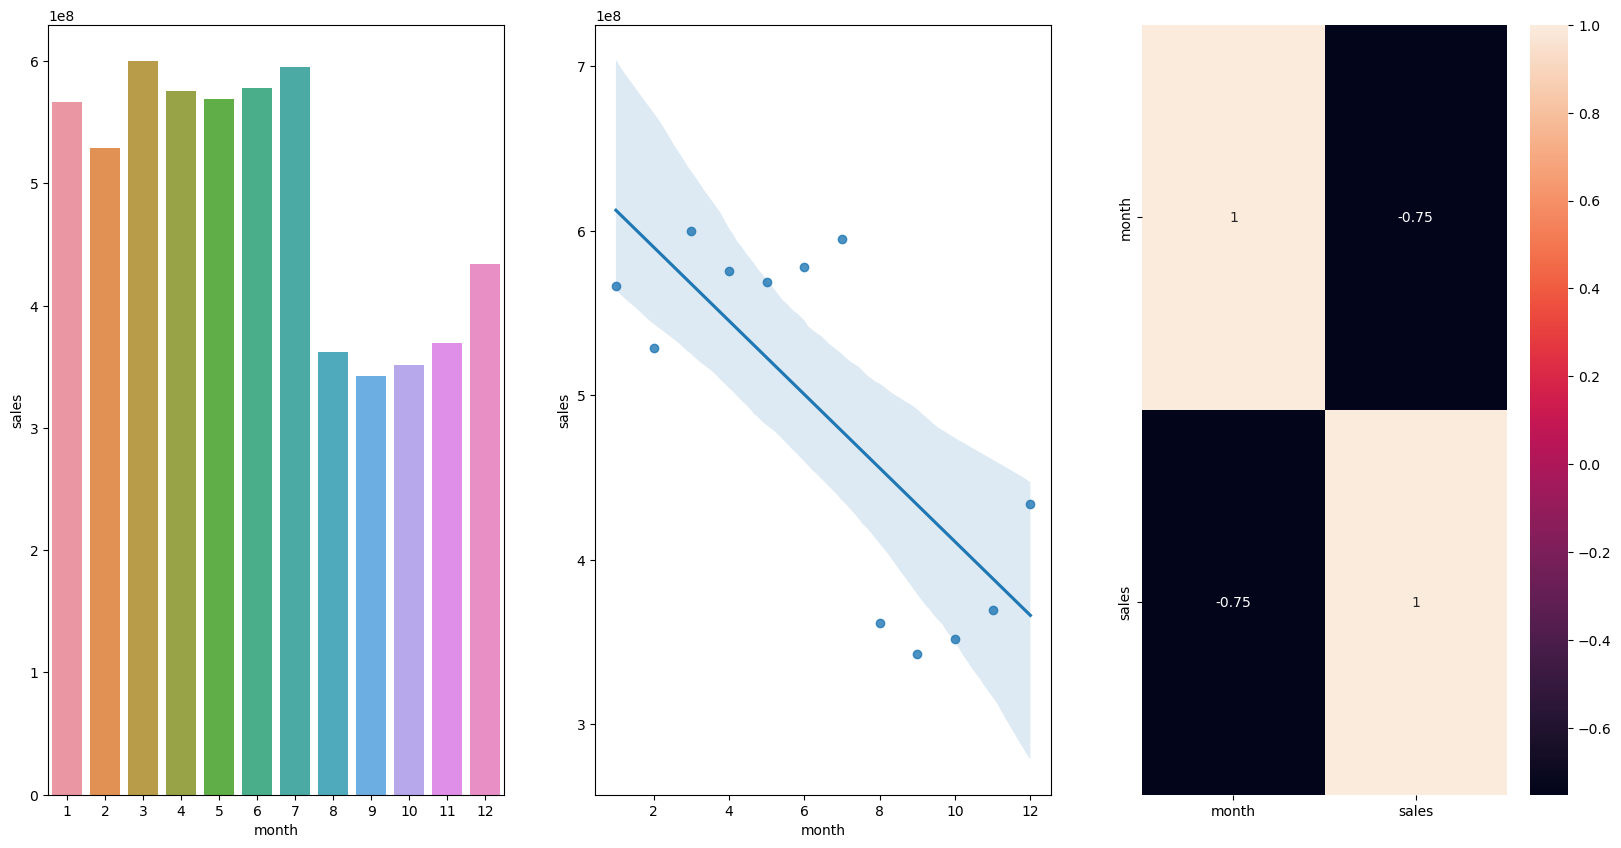

In [55]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

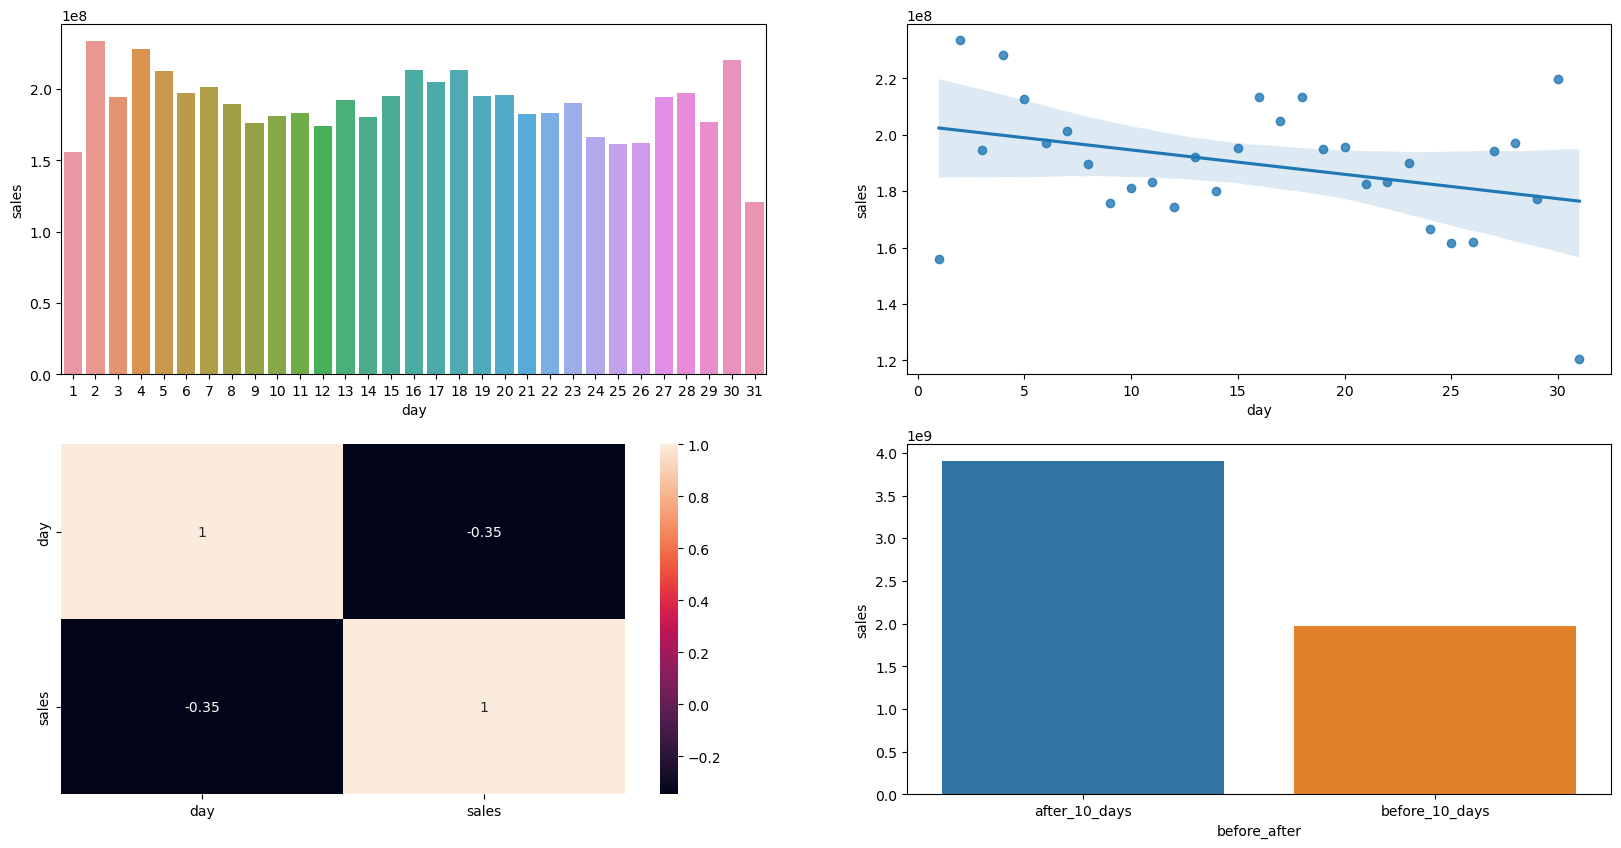

In [56]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Lojas deveriam vender menos aos finais de semana.

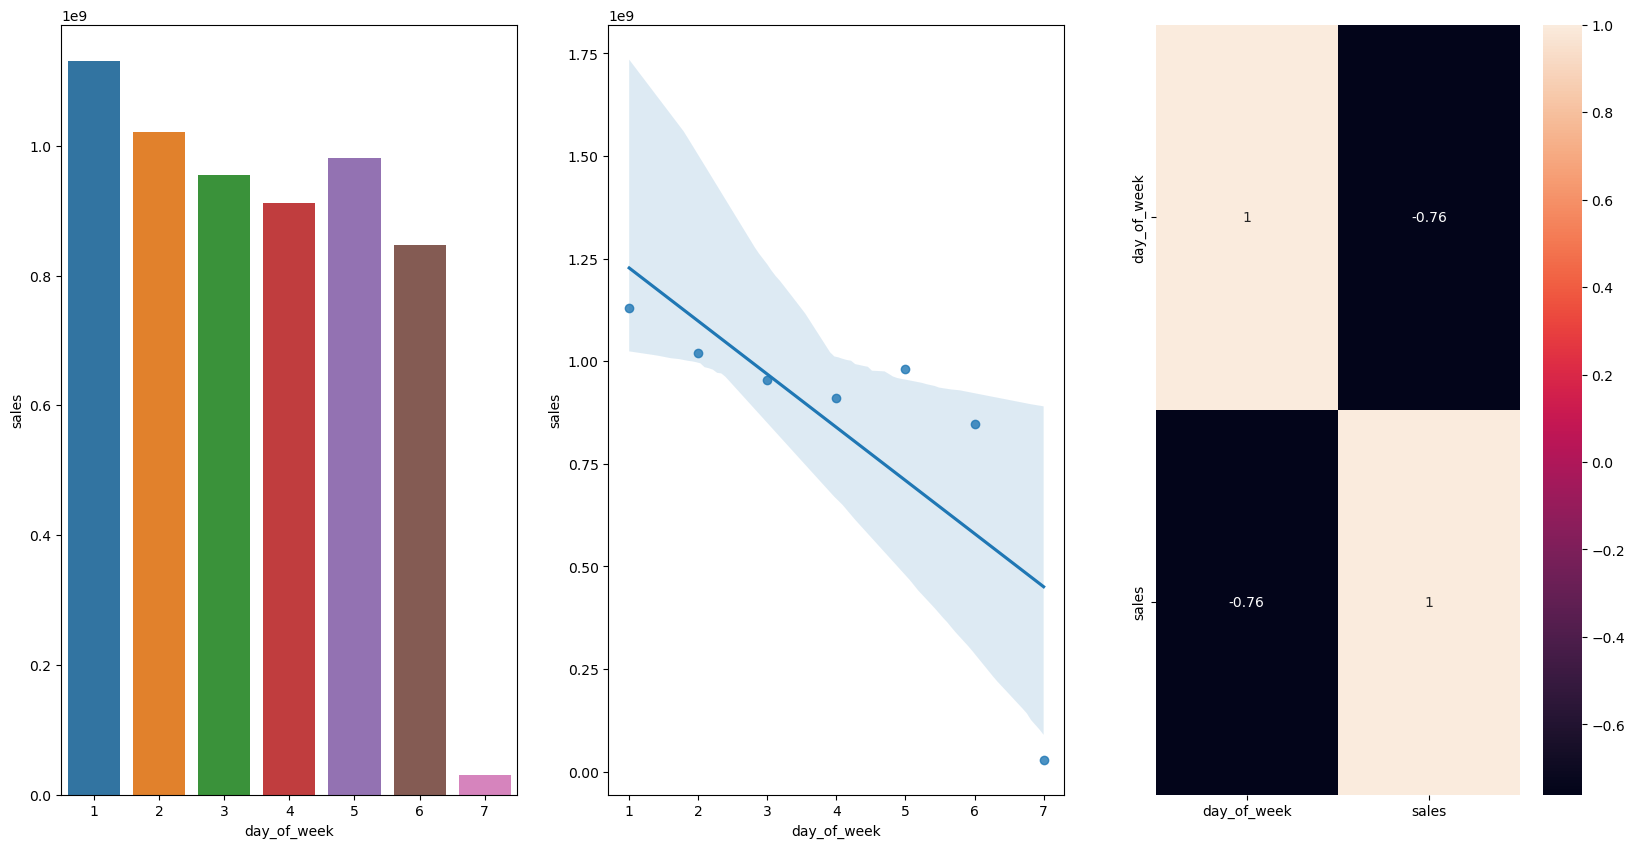

In [57]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares.

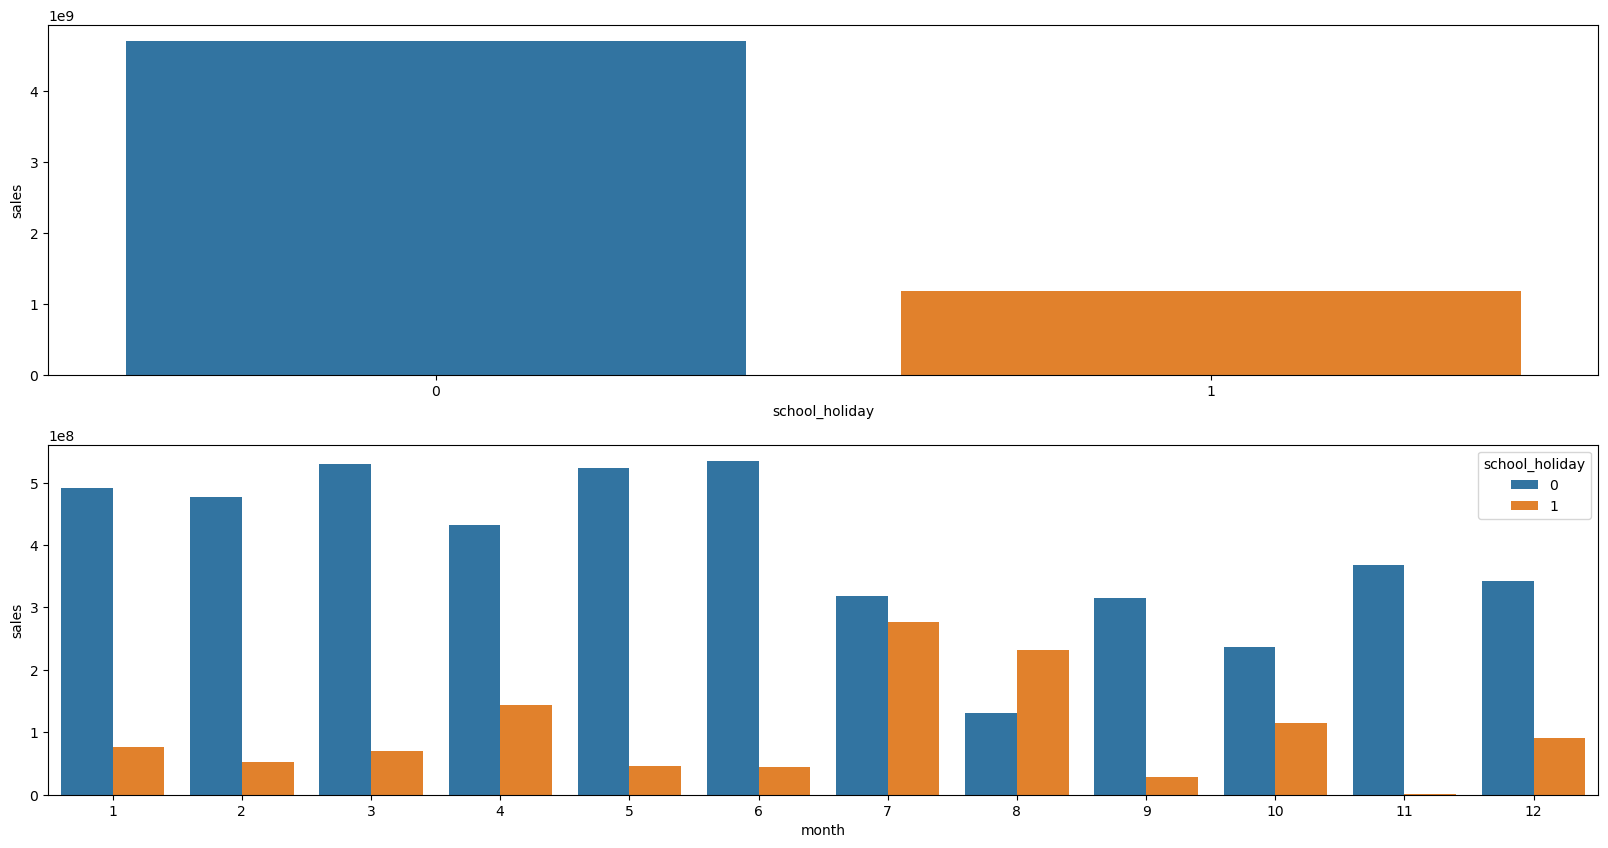

In [58]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

## 4.3 Análise Multivariada

### 4.3.1 Variáveis numéricas

<Axes: >

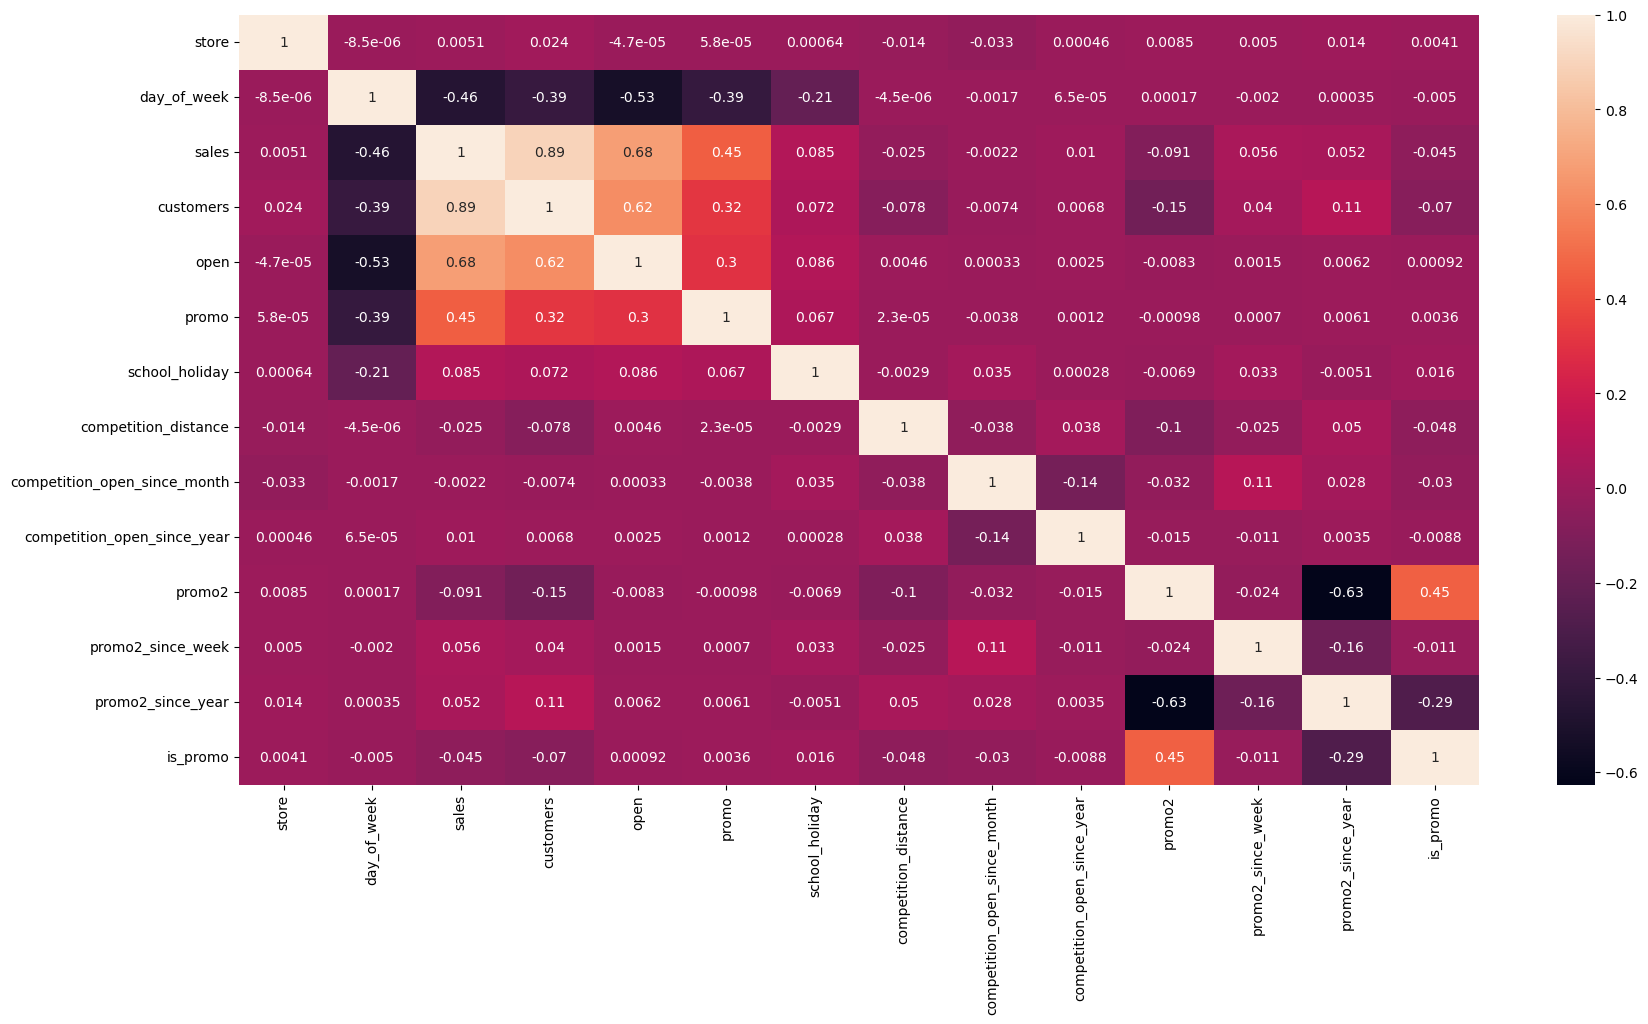

In [59]:
plt.figure(figsize=(20,10))
sns.heatmap(num_attributes.corr('pearson'), annot=True)

### 4.3.1 Variáveis Categóricas

In [60]:
a = df4.select_dtypes('object')
a

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public holiday,b,basic,2013-00
1016827,public holiday,b,extra,2013-00
1016863,public holiday,b,extra,2013-00
1017042,public holiday,b,extra,2013-00


In [61]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0,(chi2)- ((k-1)*(r-1)/n-2))

    kcorr = (k) - ((k-1)**2/(n-1))
    rcorr = (r) - ((r-1)**2/(n-1))
  

    return np.sqrt((chi2corr/n) / (min (kcorr-1,rcorr-1)))

<Axes: >

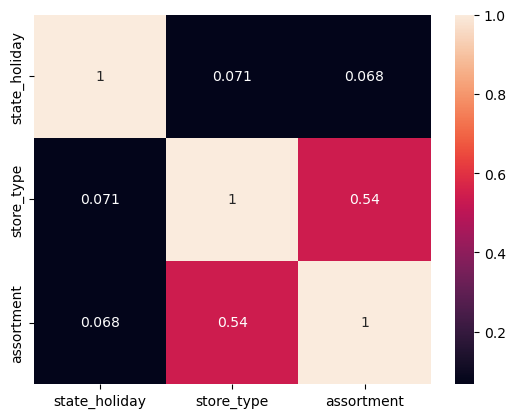

In [62]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [63]:
df5 = df4.copy() 

## 5.1 Normalization

## 5.2 Rescaling

In [64]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [65]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance']= rs.fit_transform(df5[['competition_distance']].values)

pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))


## 5.3 Transformação


### 5.3.1 Encoding

In [66]:
#state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Enconding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )
#assortment - Ordinal Encoding

assortment_dict = {'basic':1, 'extended': 2 , 'extra': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation


In [67]:
df5['sales']= np.log1p(df5['sales'])

### 5.3.3 Natural Transformation

In [68]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )

df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

# 6.0. PASSO 06 - FEATURE SELECTION

In [69]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [70]:
#quando derivamos variáveis a partir da variável orignal, precisamos deletar a variável original
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)


In [71]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [72]:
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()
# rf = RandomForestRegressor(n_jobs=-1)



In [73]:
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [74]:
# cols_selected = boruta.support_.tolist()

# ## best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# ## not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [75]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week', 'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']
# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling


In [76]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series Data Preparation - utilizando no cross validation
x_trainning = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [77]:
aux1 = x_test.copy()
aux1['sales'] = y_test

aux2 = aux1.loc[:, ['store', 'sales']].groupby(['store']).mean().reset_index().rename(columns={'sales': 'predictions'})

aux1 = pd.merge(aux1, aux2,how='left', on='store' )

yhat_baseline = aux1['predictions']

baseline_result = ml_result('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression

In [78]:
#model definition
lr = LinearRegression()

#model training

lr.fit(x_train, y_train)

#model prediction

yhat_lr = lr.predict(x_test)

#performance

lr_result = ml_result('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,2662.291292


### 7.2.1 Linear Regression + Cross Validation

In [79]:
lr_result_cv = cross_validation('LinearRegression',lr,x_trainning, 5 )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2077.72+/-295.95,0.3+/-0.02,2945.54+/-469.14


## 7.3. Linear Regression Regularized Model - Lasso

In [80]:
#model definition
lr_reg = Lasso(alpha=0.01)

#model training
lr_reg.fit(x_train, y_train)
#model prediction

yhat_reg =  lr_reg.predict(x_test)

#performance

lrr_result = ml_result('Lasso', np.expm1(y_test), np.expm1(yhat_reg))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.398669,0.289252,2743.459417


### 7.3.1 Lasso - Cross Validation

In [81]:
lrr_result_cv = cross_validation('Lasso',lr_reg,x_trainning, 5 )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.99+/-342.74,0.29+/-0.01,3058.17+/-506.07


## 7.4 Random Forest

In [82]:
# #model definition

# rf= RandomForestRegressor(n_estimators= 100, n_jobs=-1, random_state=42)

# #model training
# rf.fit(x_train, y_train)
# yhat_rf = rf.predict(x_test)

# #model performance

# rf_result = ml_result('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))



## 7.5. XGBoost Regressor 

In [83]:
model_xgb = xgb.XGBRFRegressor(objective='reg:squarederror',
n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9 ).fit( x_train, y_train )
#prediction
yhat_xgb = model_xgb.predict( x_test )
# performance
xgb_result = ml_result( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

[18:33:38] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1553.88705,0.229056,2242.4226


### 7.5.1 XGBoost Regressor - Cross Validation

In [84]:
xgb_result_cv = cross_validation('XGB',model_xgb,x_trainning, 5 )
xgb_result_cv

[18:36:06] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[18:38:51] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[18:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[18:44:36] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[18:47:16] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB,1731.09+/-246.6,0.24+/-0.01,2459.29+/-348.65


## 7.6 Compare Models Performance

### 7.6.1 Single Performance

In [85]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1553.887050,0.229056,2242.422600
0,Linear Regression,1861.127229,0.291652,2662.291292
0,Lasso,1891.398669,0.289252,2743.459417


### 7.6.2 Real Performance - Cross Validation

In [86]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result, xgb_result_cv])
modelling_result_cv.sort_values('RMSE')

,Model Name,MAE CV,MAPE CV,RMSE CV,MAE,MAPE,RMSE
0,Lasso,NaN,NaN,NaN,1891.398669,0.289252,2743.459417
0,LinearRegression,2077.72+/-295.95,0.3+/-0.02,2945.54+/-469.14,NaN,NaN,NaN
0,XGB,1731.09+/-246.6,0.24+/-0.01,2459.29+/-348.65,NaN,NaN,NaN


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING


## 8.1 Random Search 

In [87]:
# param = {
# 'n_estimators': [15, 17, 25, 30, 35],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytee': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 2

In [88]:
# final_result = pd.DataFrame()

In [89]:
# for i in range(MAX_EVAL):
#     #choose values for parameters randomly
#     hp = {k: random.sample(v,2)[0] for k, v in param.items()}
#     print(hp)
#     #model
#     model_xgb = xgb.XGBRFRegressor(objective='reg:squarederror', n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 min_child_weight=hp['min_child_weight'],
#                                 colsample_bytee=hp['colsample_bytee'] )
    
#     # performance
#     result = cross_validation('XGB',model_xgb,x_trainning, 5 )
#     final_result = pd.concat([final_result, result])

## 8.2 Final Model

In [90]:
{'n_estimators': 30, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 8}

{'n_estimators': 30,
 'eta': 0.03,
 'max_depth': 9,
 'subsample': 0.7,
 'colsample_bytee': 0.3,
 'min_child_weight': 8}

In [91]:
param_tunned ={
'n_estimators':30 ,
'eta': 0.03,
'max_depth': 9 ,
'subsample': 0.7 ,
'colsample_bytee':0.3 ,
'min_child_weight': 8 }

model_xgb_tuned = xgb.XGBRFRegressor(objective='reg:squarederror', n_estimators=param_tunned['n_estimators'],
                            eta=param_tunned['eta'],
                            max_depth=param_tunned['max_depth'],
                            subsample=param_tunned['subsample'],
                            min_child_weight=param_tunned['min_child_weight'],
                            colsample_bytee=param_tunned['colsample_bytee'] ).fit(x_train, y_train)

#predict
yhat_tunned = model_xgb_tuned.predict(x_test)

# performance
result = ml_result( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_tunned ) )

result


[18:50:46] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1629.953935,0.241877,2345.291942


# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [92]:
df9 = X_test[cols_selected_boruta_full]
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_tunned)

/tmp/ipykernel_9008/1470329190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
/tmp/ipykernel_9008/1470329190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_tunned)


## 9.1. Business Performance

In [93]:
#sum of predictions
df91 =df9.loc[:,['store', 'predictions']].groupby(['store']).sum().reset_index()


#MAE AND MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mt.mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mt.mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})


df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_aux3

df92 =pd.merge(df91, df9_aux3, how='inner', on='store')


df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [94]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
542,543,218380.406250,215125.368256,221635.444244,3255.037994,1.384287
424,425,252419.968750,248761.591375,256078.346125,3658.377375,1.247496
472,473,261187.734375,257407.849781,264967.618969,3779.884594,1.230802
434,435,235807.531250,232425.192554,239189.869946,3382.338696,1.159851
306,307,202192.671875,199370.329333,205015.014417,2822.342542,1.128373


<Axes: xlabel='store', ylabel='MAPE'>

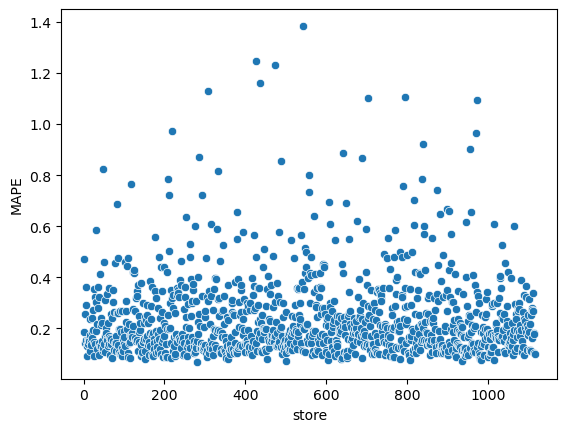

In [95]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [96]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$270,153,856.00"
1,worst_scenario,"R$268,335,811.46"
2,best_scenario,"R$271,971,867.50"


## 9.3. Machine Learning Performance

In [97]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_9008/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_9008/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/tmp/ipykernel_9008/1206153019.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df9['error'] )


<Axes: xlabel='predictions', ylabel='error'>

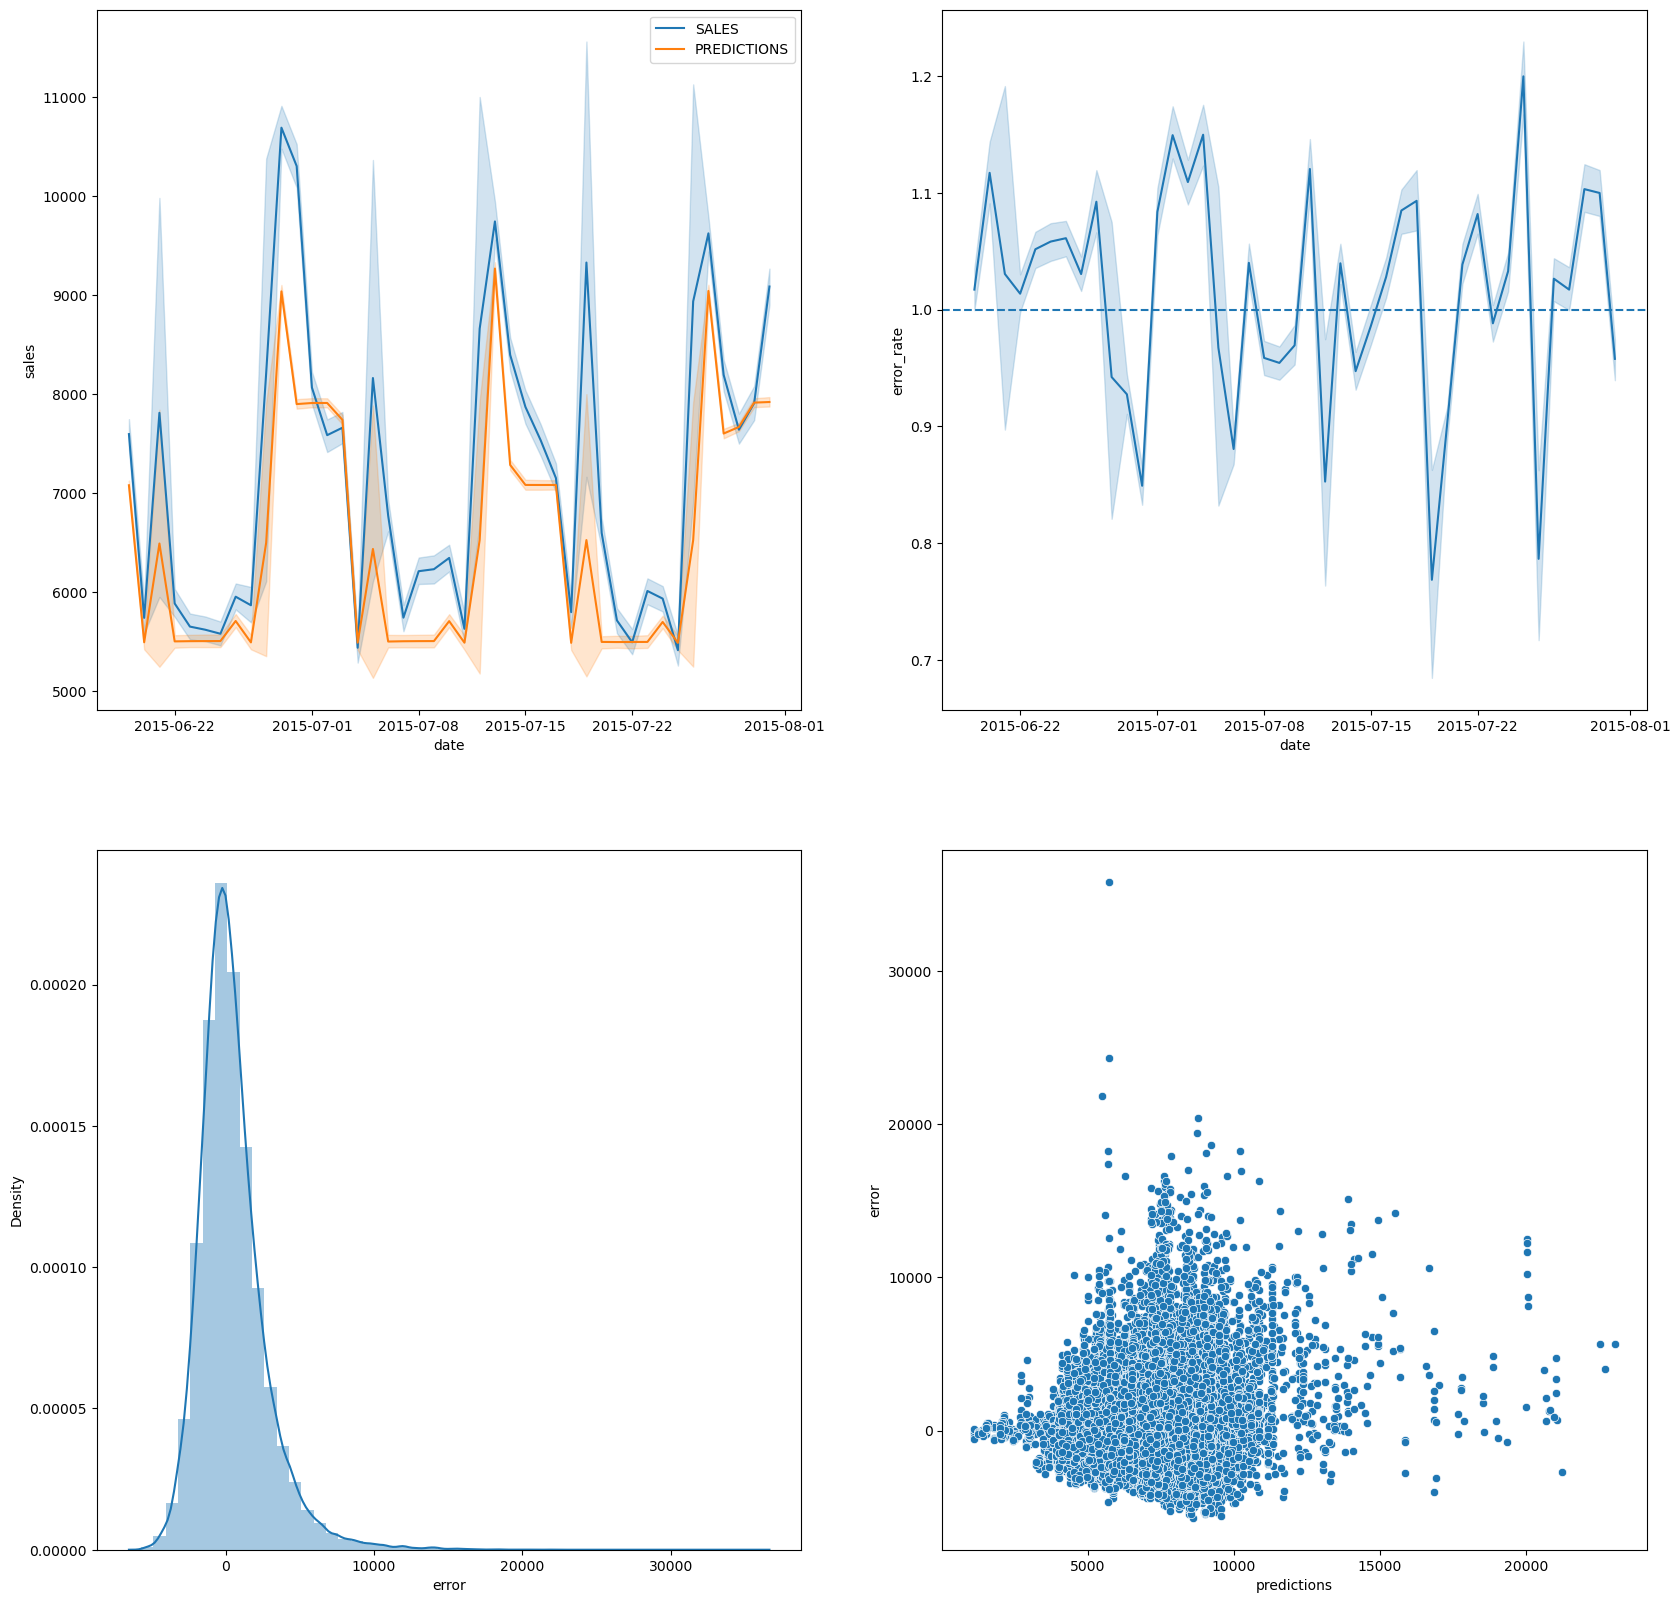

In [98]:
plt.figure(figsize=(20,20))

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot( data=df9, x= df9['predictions'], y= df9['error'])

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [99]:
#saving trained model
pickle.dump(model_xgb_tuned,open('/home/alexandrerod/Documentos/repos/DataScienceProd/model/model_rossman.pkl', 'wb'))

## 10.1 Rossman Class

In [100]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path =  '/home/alexandrerod/Documentos/repos/DataScienceProd/'
        self.competition_distance_scaler = pickle.load(open(self.home_path+'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path+'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path+'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path+'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path+ 'parameter/store_type_scaler.pkl', 'rb') )

         
    def data_cleaning(self, df1):
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
        #trocando as colunas para snake_case
        snake_case = lambda x: inflection.underscore(x)

        cols_new = list(map(snake_case, cols_old))

        # rename columns

        df1.columns = cols_new
        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
                
        ## 1.5 Fillout NA
        #### 1.5.1 competition_distance: distance in meters to the nearest competitor store

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.00 if math.isnan(x) else x)
        #### 1.5.2 competition_open_since_month: gives the approximate year and month of the time the nearest competitor was opened

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                            
        # promo2_since_week  
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year  
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
                    
                
        #### 1.5.3 Promo_interval

            
        month_map = {1 : 'Jan', 
        2 : 'Feb', 
        3 : 'Mar',
        4 : 'Apr',
        5 : 'May',
        6 : 'Jun',
        7 : 'Jul',
        8 : 'Aug',
        9 : 'Sept',
        10 : 'Oct',
        11 : 'Nov',
        12 : 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)    
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)
        ## 1.6 Change Data Types
        df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    
    def feature_engineering(self, df2):
        #year
        df2['year'] = df2['date'].dt.year
        #month
        df2['month'] = df2['date'].dt.month
        #day
        df2['day'] = df2['date'].dt.day
        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        #year-week
        df2['year_week'] = df2['date'].dt.strftime("%Y-%W")
        #competition since

        df2['competition_since'] = df2.apply(lambda x : datetime.datetime(year = x['competition_open_since_year'], month=  x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

        #promo_since
        df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w") - datetime.timedelta(days=7))
        df2['promo_time_week']=((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
        #assortment

        df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else  'extra' if x == 'b' else 'extended')

        #state_holiday

        df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public holiday' if x =='a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day') 

        # 3.0 Filtragem de Variáveis
        ## 3.1 Fitragem de Variáveis
        df2 = df2[(df2['open'] != 0)]
        ## 3.2 Selecionando Variáveis
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):
        ## 5.2 Rescaling
        df5.head()

        #competition_distance
        df5['competition_distance']= self.competition_distance_scaler.transform(df5[['competition_distance']].values)


        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ## 5.3 Transformação

        ### 5.3.1 Encoding
        #state_holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Enconding

        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])
        #assortment - Ordinal Encoding

        assortment_dict = {'basic':1, 'extended': 2 , 'extra': 3 }
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        
        ### 5.3.3 Natural Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )

        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

        cols_selected = ['store','promo', 'store_type',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_open_since_year',
            'promo2',
            'promo2_since_week',
            'promo2_since_year',
            'competition_time_month',
            'promo_time_week', 'day_of_week_sin',
            'day_of_week_cos',
            'month_sin',
            'month_cos',
            'day_sin',
            'day_cos',
            'week_of_year_sin',
            'week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction(self ,model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )
    

## 10.2 Handler API

In [101]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#load model
model = pickle.load(open('/home/alexandrerod/Documentos/repos/DataScienceProd/model/model_rossman.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods= ['POST'])

def rossmann_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        # Instantiate Rossmann class
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == "__main__":
    app.run('127.0.0.1')
    pass





ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [102]:
import json

In [103]:
df10 = pd.read_csv('/home/alexandrerod/Documentos/repos/DataScienceProd/Data/test.csv')

In [104]:
 # merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )
# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [105]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )


In [106]:
# API Call
url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /rossmann/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f590085b970>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [107]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

NameError: name 'r' is not defined

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction'] ) )